In [1]:
%pylab inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar
from scipy import math
#import pylandau
import random

Populating the interactive namespace from numpy and matplotlib


# Importo il dataset

In [2]:
file = pd.read_csv(r'/Users/giulioquaglia/Downloads/Econofisica-main-5/secondo1,75%.csv', header=18)
file.head()

,x,y,color,pen down?,x.1,y.1,color.1,pen down?.1,x.2,y.2,color.2,pen down?.2,Unnamed: 12
0,0,1120,55,True,0,0,0,True,0,0,15,True,NaN
1,1,987,55,True,1,40,0,True,1,93,15,True,NaN
2,2,667,55,True,2,96,0,True,2,357,15,True,NaN
3,3,610,55,True,3,153,0,True,3,357,15,True,NaN
4,4,612,55,True,4,203,0,True,4,305,15,True,NaN


In [3]:
df = file['y.2']
y = df.to_numpy()
y = y[210:]
x = ar(range(len(y)))
len(x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead
  after removing the cwd from sys.path.


990

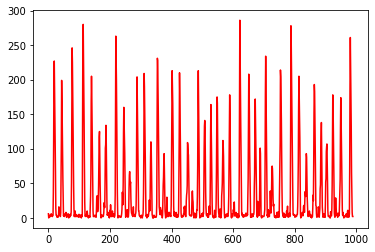

In [4]:
plt.plot(range(len(y)), y, color='r')
#plt.errorbar(range(len(soglie)), soglie, yerr=err_soglie)
plt.show()

# Definizioni Utili

## Fit Utils

In [5]:
def chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit[i])
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

def cost_chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit)
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

    
def media_pesata(x, sigma):
    numeratore = 0
    denominatore = 0
    for i in range(len(x)):
        numeratore += x[i]/(sigma[i]**2)
        denominatore += 1/(sigma[i]**2)
    return numeratore/denominatore

def costante(x,q):
    return q

def retta(x,m,q):
    return m*x +q

def gauss(x,a,x0,sigma,baseline):
    'Ritorna array gaussiano a partire da lista x secondo i parametri a,x0,sigma'
    return (baseline + a*exp(-(x-x0)**2/(2*sigma*sigma)))


def lore(x, a, x0, y0, baseline):
    'Ritorna array lorentziano a partire da lista x secondo i parametri a,x0,yo'
    return (baseline + a*(y0/(((x - x0)**2) + (y0**2))))

def fattoriale(x):
    temp_list = []

    for ics in x:
        f=1
        for i in range(1,ics+1):
            f*=i
        temp_list.append(f)
    return(temp_list)

def poisson(x, a, media, baseline):
    result = baseline + a*(media**x)*np.exp(-media)/fattoriale(x)
    return(result)

def landau(x, mpv, eta, A, baseline):
    x=double(x)
    'Ritorna array landauiano a partire da lista x secondo i parametri suoi'
    return (baseline + double(pylandau.landau(x, mpv=mpv, eta=eta, A=A)))

## Selecting Spikes

In [6]:
def isola_spikes (y, datiesterni):
    '''
    Dati i dati sugli attivi, ritorna due dizionari: 
    {num_rivolta: [valori attivi]}
    {num_rivolta: [tick corrispondenti]}
    '''
    rivolte_diz = {}
    tick_rivolte_diz = {}
    temp_rivolta_list = []
    temp_tick_list = []
    rivolte_counter = 0
    cerarivolta = False
    
    for i in range(len(y)):
        
        ##aggiustato a 12 per non avere rivoltini
        if y[i] > 12:
            temp_rivolta_list.append(y[i])
            temp_tick_list.append(i)
            if cerarivolta == False:
                rivolte_counter += 1
                cerarivolta = True
        else:
            if cerarivolta == True:
                lunghezza=len(temp_rivolta_list)
                if rivolte_counter > 1:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_rivolta_list.insert(0, y[i-lunghezza-3])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                else:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                    
                if datiesterni == 1:
                        temp_rivolta_list.append(y[i])
                        temp_tick_list.append(i)
                if datiesterni == 2:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                if datiesterni == 3:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_rivolta_list.append(y[i+2])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                        temp_tick_list.append(i+2)
                
                rivolte_diz[str(rivolte_counter)+'_spike'] = temp_rivolta_list
                tick_rivolte_diz[str(rivolte_counter)+'_spike'] = temp_tick_list
                temp_rivolta_list = []
                temp_tick_list = []
                cerarivolta = False
                
    return rivolte_diz, tick_rivolte_diz

# Analisi - rndm 1.75%

## Creo dizionario degli spikes

In [7]:
spikes_dict, tick_spikes_dict = isola_spikes(y, 3)

# Rivolte  
**HP: sono funzioni gaussiane**  
Usiamo il valore di soglia trovato nel caso non random, cambia il meccanismo di attivazione del singolo agente ma non la descrizione della rivolta.  
Selezioniamo tutte le rivolte tali per cui max#attivi+errore_attivi >= soglia-5err_soglia, queste apparterranno alla stessa categoria di rivolte trovate nel caso non rndm.  
Salvo in rivoltini_dict quelle che non vengono incluse prima per vedere se si viene a creare una nuova popolazione dovuta dalla randomizzazione (che differisce invece dalle rivolte, dovute alla clusterizzazione degli agenti)

In [8]:
soglia = 128.1241472701187
err_soglia = 12.6007119219633

In [9]:
numero_sigma_soglia = 3
numero_sigma_baseline = 3
baseline = 2

In [10]:
## Seleziono le rivolte secondo la regola:
###if soglia-5*errore_soglia < y + errore_y --> rivolta
###altrimenti salvo in rivoltini_dict
rivolte_dict = {}
tick_rivolte_dict = {}
rivoltini_dict = {}
tick_rivoltini_dict = {}
nobase_dict = {}
tick_nobase_dict = {}
rivolte_counter = 0
rivoltini_counter = 0
for spike in spikes_dict:
    y = spikes_dict[spike]
    x = tick_spikes_dict[spike]
    if np.max(y)+np.sqrt(np.max(y)) >= soglia-numero_sigma_soglia*err_soglia:
        rivolte_counter += 1
        rivolte_dict[str(rivolte_counter)+'_rivolta']=y
        tick_rivolte_dict[str(rivolte_counter)+'_rivolta']=x
        nobase_dict[str(rivolte_counter)+'_rivolta']=y
        tick_nobase_dict[str(rivolte_counter)+'_rivolta']=x
    elif np.max(y)-numero_sigma_baseline*np.sqrt(np.max(y))>=baseline+numero_sigma_baseline*np.sqrt(baseline):
        rivoltini_counter += 1 
        rivoltini_dict[str(rivoltini_counter)+'_rivoltini']=y
        tick_rivoltini_dict[str(rivoltini_counter)+'_rivoltini']=x
        nobase_dict[str(rivoltini_counter)+'_rivoltini']=y
        tick_nobase_dict[str(rivoltini_counter)+'_rivoltini']=x

In [11]:
print(len(spikes_dict), len(rivolte_dict), len(rivoltini_dict))

58 38 12


In [12]:
print(soglia-numero_sigma_soglia*err_soglia,'\n')
for risvoltino in rivoltini_dict:
    print(max(rivoltini_dict[risvoltino])+np.sqrt(max(rivoltini_dict[risvoltino])))

90.3220115042288 

37.65685424949238
75.18535277187245
59.211102550927976
35.47722557505166
45.2449979983984
61.348469228349536
27.79583152331272
28.898979485566358
45.2449979983984
83.66025403784438
44.164414002968975
34.3851648071345


In [13]:
##calcolo soglie delle rivolte come f(media-sigma) e errore come f(media-1.2*sigma)-f(media-0.8*sigma)
soglie = []
err_soglie = []
for i, rivolta in enumerate(rivolte_dict.keys()):
    
    y = rivolte_dict[rivolta]
    x = range(len(y))
    ##computo errore come radice dei conteggi
    sigma_gauss = np.where(np.sqrt(y)==0,1,np.sqrt(y))
    
    gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[200.,3.,2.5,0],sigma=sigma_gauss)
    gauss_red_chisq = chiquadronorm(y, gauss(x,*gauss_params), sigma_gauss, len(y)-len(gauss_params), norm=True)
    soglia = gauss(gauss_params[1] - gauss_params[2], *gauss_params)
    errore = gauss(gauss_params[1] - 1.2*gauss_params[2], *gauss_params) - gauss(gauss_params[1] - 0.8*gauss_params[2], *gauss_params)
    soglie.append(soglia)
    err_soglie.append(np.abs(errore))

In [14]:
##calcolo soglini delle rivoltine come f(media-sigma) e errore come f(media-1.2*sigma)-f(media-0.8*sigma)
soglini = []
err_soglini = []
for i, rivolta in enumerate(rivoltini_dict.keys()):
    
    y = rivoltini_dict[rivolta]
    x = range(len(y))
    ##computo errore come radice dei conteggi
    sigma_gauss = np.where(np.sqrt(y)==0,1,np.sqrt(y))
    
    gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[50.,3.,2.5,0.],sigma=sigma_gauss, **{'maxfev':1000000})
    gauss_red_chisq = chiquadronorm(y, gauss(x,*gauss_params), sigma_gauss, len(y)-len(gauss_params), norm=True)
    soglia = gauss(gauss_params[1] - gauss_params[2], *gauss_params)
    errore = gauss(gauss_params[1] - 1.2*gauss_params[2], *gauss_params) - gauss(gauss_params[1] - 0.8*gauss_params[2], *gauss_params)
    soglini.append(soglia)
    err_soglini.append(np.abs(errore))

## Metodo grafico  
Plotto le rivolte con relativi errori in funzione dell'ordine della rivolta,  
se il chiquadro ridotto del fit di questi valori con una costante è minore di uno, allora posso dire che gli eventi considerati sono statisticamente indipendenti e appartenenti alla stessa distribuzione

### Rivolte-Provo con costante

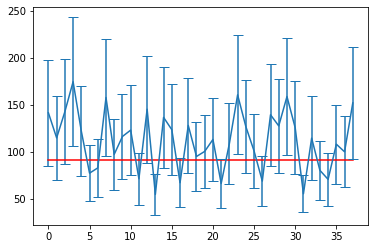

ReducedChiSquared: 0.6783695425001609


In [15]:
popt, pcov = curve_fit(costante, range(len(soglie)), soglie, sigma=err_soglie)
cost_red_chisq = cost_chiquadronorm(soglie, costante(range(len(soglie)),*popt), err_soglie, len(soglie)-len(popt), norm=True)
plt.plot(range(len(soglie)), [costante(range(len(soglie)),*popt) for k in range(len(soglie))], color='r')
plt.errorbar(range(len(soglie)), soglie, yerr=err_soglie,solid_capstyle='projecting',capsize=5)
plt.show()
print('ReducedChiSquared:', cost_red_chisq)

In [16]:
popt ,np.sqrt(pcov)

(array([91.25187519]), array([[5.01175931]]))

In [17]:
media_pesata_soglie = media_pesata(soglie, err_soglie)
err_media_pesata_soglie = np.sqrt(np.sum((soglie-media_pesata_soglie)**2)/((len(soglie)-1)*len(soglie)))
print(media_pesata_soglie, err_media_pesata_soglie)

91.2518751940363 6.195764848607049


media pesata e errore soglie caso nonrndm  
128.77802517036957 6.633983699986502

Gli eventi selezionati come rivolte hanno valori di soglia che, al netto degli errori considerati, sono considerabili come appartenenti a alla stessa distribuzione statistica.  
Rispetto al caso non random vedo però che il valore della costante (media pesata soglie) è calato e non è più compatibile (1sigma) con il valore trovato in precedenza. Se considero però gli intervalli media pesata +- 3sigma dei valori di soglia nel caso random e non random questi hanno intersezione non nulla.

### Rivoltini-Provo con costante  
oss, sono proprio sicuro che fittino con una gaussiana? non dovrei provare altre forme funzionali?

In [18]:
soglini1=[]
err_soglini1=[]
for i in range(len(soglini)):
    if soglini[i]>10 and soglini[i]<79:
        soglini1.append(soglini[i])
        err_soglini1.append(err_soglini[i])
soglini1

[23.485809723744403,
 41.45742545697009,
 20.102914669688598,
 25.163548578889614,
 13.676304760566246,
 46.32100065963446,
 21.458931724089748]

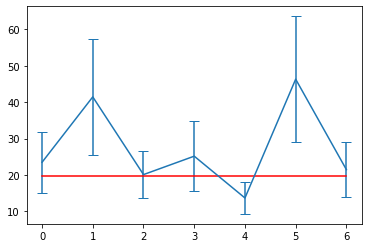

ReducedChiSquared: 1.1155552184480708


In [19]:
popt, pcov = curve_fit(costante, range(len(soglini1)), soglini1, sigma=err_soglini1)
cost_red_chisq = cost_chiquadronorm(soglini1, costante(range(len(soglini1)),*popt), err_soglini1, len(soglini1)-len(popt), norm=True)
plt.plot(range(len(soglini1)), [costante(range(len(soglini1)),*popt) for k in range(len(soglini1))], color='r')
plt.errorbar(range(len(soglini1)), soglini1, yerr=err_soglini1,solid_capstyle='projecting',capsize=5)
plt.show()
print('ReducedChiSquared:', cost_red_chisq)

In [20]:
media_pesata_soglini1 = media_pesata(soglini1, err_soglini1)
err_media_pesata_soglini1 = np.sqrt(np.sum((soglini1-media_pesata_soglini1)**2)/((len(soglini1)-1)*len(soglini1)))
print(media_pesata_soglini1, err_media_pesata_soglini1)

19.810150071352286 5.464228543860812


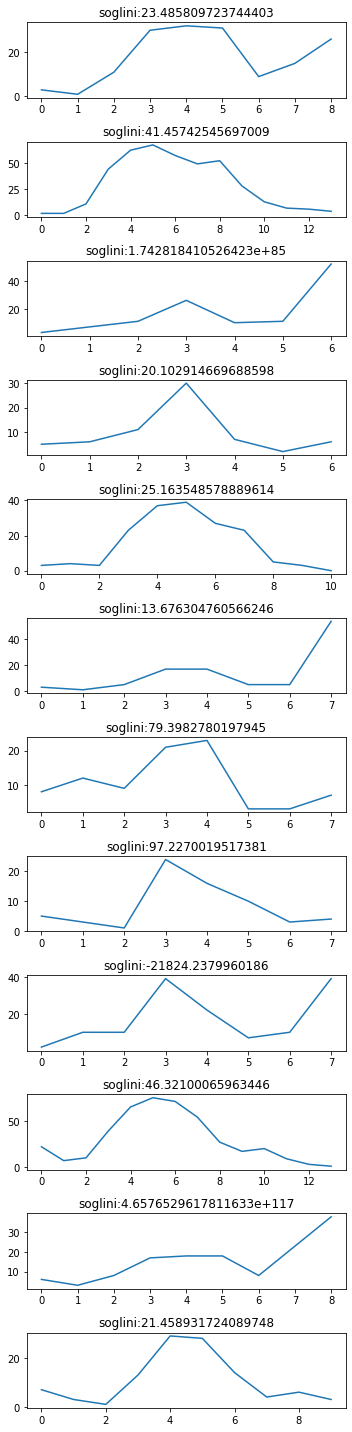

In [21]:
fig, ax = plt.subplots(nrows=len(rivoltini_dict.keys()), ncols=1, figsize=(5,20))

for i,rivoltini in enumerate(rivoltini_dict.keys()):
    ax[i].plot(range(len(rivoltini_dict[rivoltini])), rivoltini_dict[rivoltini])
    ax[i].set_title('soglini:' + str(soglini[i]))
    
fig.tight_layout()
plt.show()

In [39]:
sogl= {'soglie 1.75%': soglie, 'err_soglie': err_soglie}
df= pd.DataFrame(data=sogl)
soglin={'soglini 1.75%': soglini1, 'err_soglini':err_soglini1}
df1= pd.DataFrame(data=soglin)
with pd.ExcelWriter('soglie_soglini_2.xlsx',engine='openpyxl',mode='a') as writer:  
    df.to_excel(writer, sheet_name='soglie')
    df1.to_excel(writer, sheet_name='soglini')
    writer.save()

writer.close()

I rivoltini invece, hanno un chiquadro ridotto superiore a uno.  
Non sembrerebbe si tratti della stessa popolazione statistica, ma probabilmente questo è dovuto ai piccoli errori sui valori di soglia più piccoli

# Metriche  
Tutte le metriche vengono ricavate dal calcolo dei parametri derivanti dalla procedura di fit:  
- Durata = 6sigma della rivolta considerata  
- Tempo attesa = (media[rivolta_i+1] - 3sigma[rivolta_i+1]) - (media[rivolta_i] + 3sigma[rivolta_i])  
- Ampiezza = parametro del fit  
  
Gli errori vengono calcolati dalla propagazione degli errori sui parametri del fit

In [22]:
## For loop che mi serve a trovare ampiezza, media e deviazione standard di ognuna delle rivolte,
###salvo i parametri del fit per ognuna delle rivolte
gauss_params_dict = {}
gauss_err_params_dict = {}
for rivolte in rivolte_dict:

    temp_list = []
    temp_err_list = []
    y = rivolte_dict[rivolte]
    x = tick_rivolte_dict[rivolte]
    
    err_y = np.where(np.sqrt(y)==0,1,np.sqrt(y))
    gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[200,((x[-1]-x[0])/2)+x[0],4.,0.],sigma=err_y)
    temp_list.append(gauss_params[0])
    temp_list.append(gauss_params[1])
    temp_list.append(gauss_params[2])
    temp_list.append(gauss_params[3])
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[0][0])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[1][1])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[2][2])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[3][3])))
    gauss_params_dict[rivolte] = temp_list
    gauss_err_params_dict[rivolte] = temp_err_list

In [23]:
## For loop che mi serve a trovare ampiezza, media e deviazione standard di ognuna delle rivolte,
###salvo i parametri del fit per ognuna delle rivolte
nobase_gauss_params_dict = {}
nobase_gauss_err_params_dict = {}
for rivolte in nobase_dict:

    temp_list = []
    temp_err_list = []
    y = nobase_dict[rivolte]
    x = tick_nobase_dict[rivolte]
    
    err_y = np.where(np.sqrt(y)==0,1,np.sqrt(y))
    gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[100,((x[-1]-x[0])/2)+x[0],4.,0.],sigma=err_y,**{'maxfev':100000})
    temp_list.append(gauss_params[0])
    temp_list.append(gauss_params[1])
    temp_list.append(gauss_params[2])
    temp_list.append(gauss_params[3])
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[0][0])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[1][1])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[2][2])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[3][3])))
    nobase_gauss_params_dict[rivolte] = temp_list
    nobase_gauss_err_params_dict[rivolte] = temp_err_list

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [24]:

pd.DataFrame.from_dict(nobase_gauss_err_params_dict, orient='index')

,0,1,2,3
1_rivolta,2.812561e+01,1.861231e-01,1.361604e-01,2.129463e+00
2_rivolta,1.605071e+01,1.278936e-01,1.128257e-01,1.912392e+00
3_rivolta,1.886815e+01,1.252863e-01,1.036581e-01,1.771430e+00
4_rivolta,4.071124e+01,2.113125e-01,1.611954e-01,3.675619e+00
5_rivolta,1.255612e+01,9.530274e-02,8.426481e-02,1.144819e+00
1_rivoltini,1.249452e+01,3.825720e-01,3.961132e-01,3.232140e+00
6_rivolta,1.865804e+01,2.273403e-01,2.139614e-01,2.609581e+00
7_rivolta,1.227076e+01,1.421646e-01,1.184975e-01,1.528016e+00
8_rivolta,2.487587e+01,1.385080e-01,1.064805e-01,1.722236e+00
9_rivolta,1.951663e+01,2.023747e-01,1.632928e-01,1.795710e+00


In [25]:
del nobase_gauss_params_dict['3_rivoltini']
del nobase_gauss_err_params_dict['3_rivoltini']
del nobase_gauss_params_dict['9_rivoltini']
del nobase_gauss_err_params_dict['9_rivoltini']
del nobase_gauss_params_dict['11_rivoltini']
del nobase_gauss_err_params_dict['11_rivoltini']
del nobase_gauss_params_dict['7_rivoltini']
del nobase_gauss_err_params_dict['7_rivoltini']
del nobase_gauss_params_dict['6_rivoltini']
del nobase_gauss_err_params_dict['6_rivoltini']
del nobase_gauss_params_dict['4_rivoltini']
del nobase_gauss_err_params_dict['4_rivoltini']
del nobase_gauss_params_dict['8_rivoltini']
del nobase_gauss_err_params_dict['8_rivoltini']

## Durata

In [26]:
## calcolo la durata delle singole rivolte come 6 per la sigma della rivolta (hp:gaussiane)
###e errori su singole durate propagando gli errori sulla sigma (6*err_assoluto sigma)
durate_list = [gauss_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
err_durate_list = [gauss_err_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
durate_list = np.abs(durate_list)
err_durate_list = np.abs(err_durate_list)

## calcolo media pesata e errore su media
media_pesata_durate = media_pesata(durate_list, err_durate_list)
err_media_pesata_durate = np.sqrt(np.sum((durate_list - media_pesata_durate)**2)/(len(durate_list)*(len(durate_list)-1)))

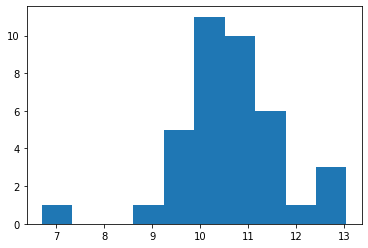

In [27]:
plt.hist(durate_list, bins=10)
plt.show()

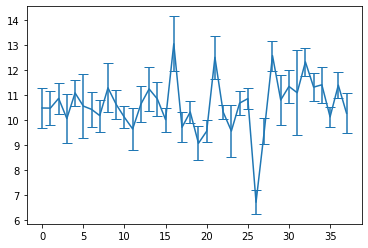

In [28]:
plt.errorbar(range(len(durate_list)), durate_list, yerr=err_durate_list,solid_capstyle='projecting',capsize=5)
plt.show()

In [29]:
print(media_pesata_durate,err_media_pesata_durate)

10.414361017589474 0.1811014207703488


media pesata durate e errore caso norndm  
10.311830447971328 0.12035386293573513
  
valori compatibili tra loro

## Ampiezza

In [30]:
## Calcolo ampiezze per ogni rivolta e errore da propagazione errori del fit
ampiezze_list = [gauss_params_dict[rivolte][0] for rivolte in rivolte_dict]
err_ampiezze_list = [gauss_err_params_dict[rivolte][0] for rivolte in rivolte_dict]
ampiezze_list = np.abs(ampiezze_list)
err_ampiezze_list = np.abs(err_ampiezze_list)

## Calcolo media pesata e errore su media
media_pesata_ampiezze = media_pesata(ampiezze_list, err_ampiezze_list)
err_media_pesata_ampiezze = np.sqrt(np.sum((ampiezze_list - media_pesata_ampiezze)**2)/(len(ampiezze_list)*(len(ampiezze_list)-1)))

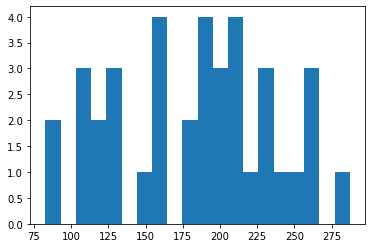

In [31]:
plt.hist(ampiezze_list, bins=20)
plt.show()

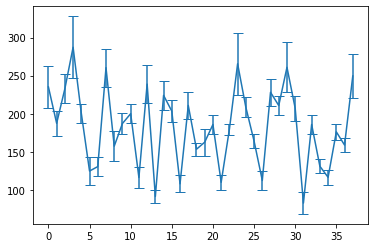

In [32]:
plt.errorbar(range(len(ampiezze_list)), ampiezze_list, yerr=err_ampiezze_list,solid_capstyle='projecting',capsize=5)
plt.show()

In [33]:
print(media_pesata_ampiezze,err_media_pesata_ampiezze)

160.6331017174604 9.380319075614825


Media pesata e errore ampiezze caso nonrndm  
193.59670978171002 14.655492080565837

## Tempi attesa

In [34]:
## calcolo liste dei tick di inizio e fine rivolte con relativi errori 
###trovati con propagazione degli errori dagli errori dei parametri del fit
###(start = media-3sigma --> err_start = sqrt(err_media**2 + (3err_sigma)**2)
start_tick_list = []
end_tick_list = []
err_start_tick_list = []
err_end_tick_list = []

for rivolte in nobase_gauss_params_dict:
    media = nobase_gauss_params_dict[rivolte][1]
    sigma = np.abs(nobase_gauss_params_dict[rivolte][2])
    err_media = nobase_gauss_err_params_dict[rivolte][1]
    err_sigma = nobase_gauss_err_params_dict[rivolte][2]
    start_tick_list.append(media - 3*sigma)
    end_tick_list.append(media + 3*sigma)
    err_start_tick_list.append(np.sqrt(err_media**2 + (3*err_sigma)**2))
    err_end_tick_list.append(np.sqrt(err_media**2 + (3*err_sigma)**2))

In [35]:
## Calcolo tempi di attesa dalle liste dei tick di inizio e fine rivolte e relativi errori
###calcolati con la propagazione dagli errori dei tick di inizio e fine rivolte
###(tempo_attesa = start[i+1]-end[i] --> err_tempo_attesa = err_start[i+1] + err_end[i])
tempi_attesa_list = []
err_tempi_attesa_list = []
for i in range(len(end_tick_list)-1):
    tempi_attesa_list.append(start_tick_list[i+1] - end_tick_list[i])
    err_tempi_attesa_list.append(err_start_tick_list[i+1] + err_end_tick_list[i])

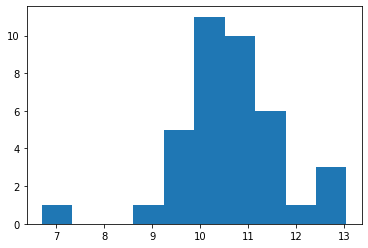

In [36]:
plt.hist(durate_list, bins=10)
plt.show()

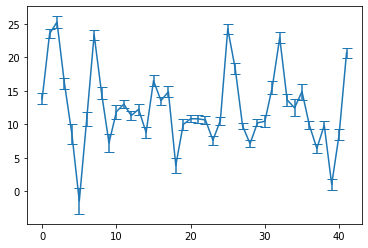

In [37]:
plt.errorbar(range(len(tempi_attesa_list)), tempi_attesa_list, yerr=err_tempi_attesa_list,solid_capstyle='projecting',capsize=5)
plt.show()

In [38]:
media_pesata_tempi_attesa = media_pesata(tempi_attesa_list, err_tempi_attesa_list)
err_media_pesata_tempi_attesa = np.sqrt(np.sum((tempi_attesa_list-media_pesata_tempi_attesa)**2)/((len(tempi_attesa_list)-1)*len(tempi_attesa_list)))
print('Media pesata e errore tempi attesa:',media_pesata_tempi_attesa,err_media_pesata_tempi_attesa)

Media pesata e errore tempi attesa: 12.430507962348907 0.9106107986054521


media pesata e errori tempi attesa caso norndm  
17.850298917848043 1.0515878508062226

Tempi di attesa diminuiscono
Sembra ok, data la contemporanea presenza di più attivi e la nascita di una nuova classe di rivolte, sembra logico che gli spike diventino più frequenti